#### Higher school of econimics
#### Name: Zhornichenko Ilya
#### Gruop: TMSS

### Using pre-trained model

Today we're going to build and fine-tune CNN based on weights pre-trained on ImageNet: the largest image classification dataset as of now.
More about imagenet: http://image-net.org/
Setup: classify from a set of 1000 classes.

In [1]:
import requests

# class labels
LABELS_URL = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
labels = {i: c for i, c in enumerate(requests.get(LABELS_URL).json())}

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
print(list(labels.items())[:5])

[(0, 'tench'), (1, 'goldfish'), (2, 'great white shark'), (3, 'tiger shark'), (4, 'hammerhead shark')]


### TorchVision
PyTorch has several companion libraries, one of them being [torchvision](https://github.com/pytorch/vision/tree/master/) - it contains a number of popular vision datasets, preprocessing tools and most importantly, [pre-trained models](https://github.com/pytorch/vision/tree/master/torchvision/models).

For now, we're going to use torch Inception-v3 module.

We're gonna use the inception-v3 network:
![img](https://hackathonprojects.files.wordpress.com/2016/09/googlenet_diagram.png?w=650&h=192)

Let's first look at the code here: [url](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py)

In [2]:
from torchvision.models.inception import inception_v3

model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
model.train(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [4]:
import torch

dummy_x = torch.randn(5, 3, 299, 299)
model(dummy_x)

tensor([[-1.0087,  1.2016,  2.2485,  ..., -2.2082, -0.5630,  1.8668],
        [-0.9761,  0.9424,  1.8791,  ..., -2.3048, -0.5994,  1.5059],
        [-1.2072,  0.8171,  1.1025,  ..., -1.9671, -0.3215,  1.8132],
        [-0.9851,  0.8057,  2.0042,  ..., -2.2301, -0.4549,  1.1951],
        [-1.1583,  0.6839,  1.8461,  ..., -2.0468, -0.6462,  1.4762]],
       grad_fn=<AddmmBackward0>)

### Predict class probabilities

In [3]:
# If using Colab
!mkdir sample_images
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg -O sample_images/albatross.jpg

mkdir: cannot create directory ‘sample_images’: File exists
--2022-11-13 19:00:51--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11607 (11K) [image/jpeg]
Saving to: ‘sample_images/albatross.jpg’

sample_images/albat 100%[===================>]  11.33K  --.-KB/s    in 0s      

2022-11-13 19:00:51 (72.0 MB/s) - ‘sample_images/albatross.jpg’ saved [11607/11607]



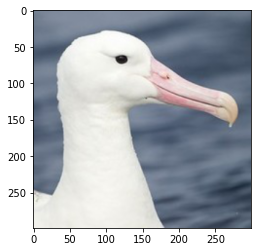

top-10 classes are: 
 [prob : class label]
0.9745 :	albatross
0.0030 :	turnstile
0.0005 :	Shetland Sheepdog
0.0005 :	llama
0.0003 :	collie
0.0003 :	duck
0.0003 :	hammerhead shark
0.0003 :	nipple
0.0003 :	Polaroid camera


In [5]:
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline

img = resize(plt.imread('sample_images/albatross.jpg'), (299, 299))
plt.imshow(img)
plt.show()


def transform_input(img):
    return torch.as_tensor(img.reshape([1, 299, 299, 3]).transpose([0, 3, 1, 2]), dtype=torch.float32)


def predict(img):
    img = transform_input(img)
    
    probs = torch.nn.functional.softmax(model(img), dim=-1)
    
    probs = probs.data.numpy()
    
    top_ix = probs.ravel().argsort()[-1:-10:-1]
    print ('top-10 classes are: \n [prob : class label]')
    for l in top_ix:
        print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))
        

predict(img)

### Having fun with pre-trained nets

In [6]:
!wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O img.jpg

--2022-11-13 19:00:59--  http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Resolving cdn.com.do (cdn.com.do)... 172.67.204.223, 104.21.61.15, 2606:4700:3037::6815:3d0f, ...
Connecting to cdn.com.do (cdn.com.do)|172.67.204.223|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg [following]
--2022-11-13 19:00:59--  https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Connecting to cdn.com.do (cdn.com.do)|172.67.204.223|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51048 (50K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  49.85K  --.-KB/s    in 0s      

2022-11-13 19:00:59 (120 MB/s) - ‘img.jpg’ saved [51048/51048]



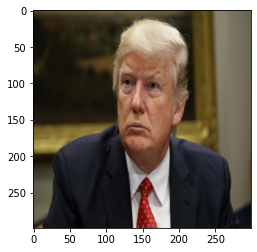

top-10 classes are: 
 [prob : class label]
0.6924 :	suit
0.0912 :	Windsor tie
0.0627 :	bridegroom
0.0045 :	oboe
0.0040 :	academic gown
0.0034 :	slip-on shoe
0.0032 :	wig
0.0028 :	Afghan Hound
0.0027 :	bow tie


In [7]:
img = resize(plt.imread('img.jpg'), (299, 299))
plt.imshow(img)
plt.show()

predict(img)

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [8]:
!wget -nc https://www.dropbox.com/s/ae1lq6dsfanse76/dogs_vs_cats.train.zip?dl=1 -O data.zip
# if the link does not work, you can download the dataset manually from https://disk.yandex.ru/d/nuyCNaDrE1Bq0w
!unzip -n data.zip

File ‘data.zip’ already there; not retrieving.
Archive:  data.zip


### How to get features
During good old days in Torch7 you could access any intermediate output from the sequential model. Nowadays it's a bit more difficult though it's not Tensorflow where you need to compile another model for that. Here we're going to redefine the last layer... yes, to do nothing.

In [12]:
from copy import deepcopy  # in case you still need original model

embedding = deepcopy(model)

class Identity(torch.nn.Module):

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
        
    
# redefine the last layer to be Identity
embedding.fc = Identity()
assert embedding(transform_input(img)).data.numpy().shape == (1, 2048), "your output for single image should have shape (1, 2048)"

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [12]:
#extract features from images
from tqdm import tqdm
from skimage.io import imread
import PIL.Image as Image
import os
import numpy as np

X = []
Y = []

batch_size = 32
imgs = np.zeros([batch_size, 299, 299, 3])
batch_index = 0

for fname in tqdm(os.listdir('train')):
    
    y = fname.startswith("cat")
    Y.append(y)
    
    img = imread(os.path.join("train", fname))
    
    img = np.array(Image.fromarray(img).resize((299, 299))) / 255.
    imgs[batch_index] = img
    
    if batch_index == batch_size - 1:
        input_tensor = torch.as_tensor(imgs.transpose([0,3,1,2]), dtype=torch.float32)
    
        # use your embedding model to produce feature vector
        features = embedding(input_tensor).data.numpy()
        
        X.append(features)
        
        batch_index = 0
        continue
        
    batch_index += 1

100%|██████████| 25000/25000 [2:13:47<00:00,  3.11it/s]


In [13]:
X = np.concatenate(X) #stack all [1xfeatures] matrices into one. 
assert X.ndim == 2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = np.array(Y[:len(X)])

print(X.shape, Y.shape)

(24992, 2048) (24992,)


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [16]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [18]:
clf = SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9831955188050147

In [19]:
clf = RandomForestClassifier().fit(X_train, y_train)
clf.score(X_test, y_test)

0.9798612963456922

In [21]:
clf = LogisticRegression().fit(X_train, y_train)
clf.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.9857295278740997

# Main quest

* Get the score improved!
* You have to reach __at least 95%__ on the test set. More = better.

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.


### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k

### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output

### Train the newly added layers for some iterations
  * you can selectively train some weights by sending the correct parameters in the optimizer
      * `opt = torch.optim.Adam([head_only.parameters()])``
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

In [25]:
embedding.fc = nn.Sequential(
          nn.Linear(2048, 2),
          nn.Sigmoid()
        ) 

In [26]:
#extract features from images
from tqdm import tqdm
from skimage.io import imread
import PIL.Image as Image
import os
import numpy as np

X = []
Y = []

batch_size = 32
imgs = np.zeros([batch_size, 299, 299, 3])
batch_index = 0

for fname in tqdm(os.listdir('train')):
    
    y = fname.startswith("cat")
    Y.append(y)
    X.append(os.path.join("train", fname))

100%|██████████| 25000/25000 [00:00<00:00, 538338.64it/s]


In [15]:
X = np.array(X)
Y = np.array(Y)

In [16]:
all_idxs = np.arange(len(X))
np.random.shuffle(all_idxs)
train_idxs = all_idxs[:15000]
val_idxs = all_idxs[15000: 20000]
test_idxs = all_idxs[20000:]
train_X = X[train_idxs]
train_y = Y[train_idxs]
val_X = X[val_idxs]
val_y = Y[val_idxs]
test_X = X[test_idxs]
test_y = Y[test_idxs]

In [27]:
class Data(Dataset):
  def __init__(self, X, y):
    self.images = X
    self.label = y
    # предобработка данных
    self.transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Resize((299, 299))
    ])
  
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img = self.transform(imread(self.images[idx]))
    return img, int(self.label[idx])

In [28]:
train_dataset = Data(train_X, train_y)
val_dataset =  Data(val_X, val_y)

In [19]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [20]:
dataloaders = {
    'train':train_loader, 
    'val': val_loader
}
dataset_sizes = {
    'train':train_X.shape[0],
    'val':val_X.shape[0]
}

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [31]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [32]:
embedding = embedding.to(device)
criterion =  nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(embedding.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [33]:
model_ft = train_model(embedding, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.3754 Acc: 0.9701
val Loss: 0.3263 Acc: 0.9934

Epoch 1/4
----------
train Loss: 0.3280 Acc: 0.9904
val Loss: 0.3222 Acc: 0.9930

Epoch 2/4
----------
train Loss: 0.3230 Acc: 0.9934
val Loss: 0.3215 Acc: 0.9932

Epoch 3/4
----------
train Loss: 0.3204 Acc: 0.9947
val Loss: 0.3201 Acc: 0.9938

Epoch 4/4
----------
train Loss: 0.3177 Acc: 0.9976
val Loss: 0.3196 Acc: 0.9940

Training complete in 28m 3s
Best val Acc: 0.994000


In [34]:
test_dataset =  Data(test_X, test_y)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

test accuracy

In [37]:
running_corrects = 0

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    # statistics
    running_corrects += torch.sum(preds == labels.data)
epoch_acc = running_corrects.double() / test_dataset.__len__()

print(f' Acc: {epoch_acc:.4f}')

 Acc: 0.9938


# Bonus: #deepdream

https://twitter.com/search?q=%23deepdream&src=typd

Code is heavily based on https://github.com/thesemicolonguy/deep-dream-pytorch

Original blogpost where more ideas can be taken from: https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html

In [22]:
from PIL import Image, ImageFilter, ImageChops
from torchvision import transforms
import numpy as np

In [23]:
modulelist = list(model.children())

In [24]:
preprocess = transforms.Compose([
#    transforms.Resize((299, 299)),  # do we really need this now?
    transforms.ToTensor()#,
    ])


def dd_helper(image, layer, iterations, lr):
    input_var = torch.as_tensor(preprocess(image).unsqueeze(0), requires_grad=True, dtype=torch.float32)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data
    
    input_im = input_var.data.squeeze()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [25]:
def deep_dream(image, layer, iterations, lr, octave_scale, num_octaves):
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if (image1.size[0] / octave_scale < 1 or image1.size[1] / octave_scale < 1):
            size = image1.size
        else:
            size = (int(image1.size[0] / octave_scale), int(image1.size[1] / octave_scale))
            
        image1 = image1.resize(size, Image.ANTIALIAS)
        image1 = deep_dream(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size, Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)
    print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

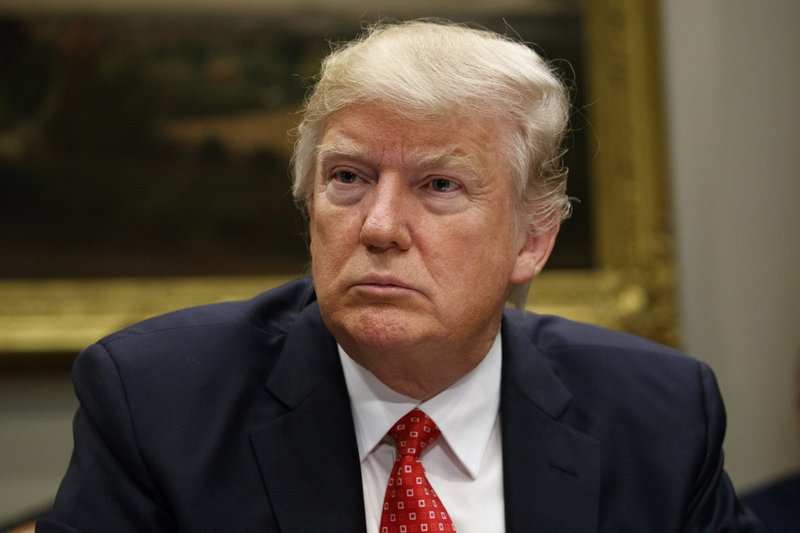

In [26]:
img = Image.fromarray(plt.imread('img.jpg'))
img

In [27]:
output = deep_dream(img, 5, 5, 0.3, 2, 20)

-------------- Recursive level:  0 --------------


TypeError: ignored

In [ ]:
output = deep_dream(img, 12, 5, 0.2, 2, 1)

# Bonus 2: Adversarial Attack

Original PyTorch tutorial is [here](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)

In [ ]:
# Change the Deep Dream step function
# to make it doing adversarial example from original image


def dd_helper_modified(image, layer, iterations, lr):
    input_var = torch.as_tensor(preprocess(image).unsqueeze(0), requires_grad=True, dtype=torch.float32)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):  # maybe change this
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data # and probably this
    input_im = input_var.data.squeeze()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [ ]:
img = Image.fromarray(plt.imread('img.jpg'))
img_adv = dd_helper(img, ?, ?, ?)
img_adv

In [ ]:
predict(resize(np.asarray(img_adv), (299, 299)))